# **OK!**

# **Modelo de Sistema de Recomendación - GRUPOREFERENCIA**
# **Algoritmo RandomForestClassifier**

In [1]:
import os
import psutil

# Memoria
print(f"Memoria total: {psutil.virtual_memory().total / 1e9:.2f} GB")  # Si muestra >16GB → probablemente remoto

# CPU
print(f"Núcleos lógicos: {os.cpu_count()}")  # >8 cores → servidor dedicado

Memoria total: 16.62 GB
Núcleos lógicos: 8


In [2]:
import pandas as pd
import numpy as np
import random
import joblib

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import (f1_score,
                             matthews_corrcoef,
                             cohen_kappa_score)
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.ensemble import RandomForestClassifier

In [3]:
from dav_cas.tools.eva_mod import classification_report_df
from dav_cas.tools.graficos import conf_matrix_normalized_sn

In [4]:
# Semillas para reproducibilidad
SEED = 7
SEED_SPLIT = 7
os.environ['PYTHONHASHSEED'] = f'{SEED}'  # Para operaciones hash en Python
np.random.seed(SEED)                   # Semilla para numpy
random.seed(SEED)

In [5]:
basedir = os.getcwd()

## **1- Carga de los datos SB11_SBPro_UDENAR_01_00:**

## **(Data #4)**

In [6]:
CAR_NOM = '01' # Características nominales
CAR_ORD = '00' # Características ordinales

In [7]:
X = pd.read_csv(os.path.join(basedir, f'data/data_icfes/SB11_SBPro/SB11_SBPro_UDENAR_{CAR_NOM}_{CAR_ORD}.csv'))

## **2- Carga los valores de 'y' (GRUPOREFERENCIA):**

In [8]:
y = pd.read_csv(os.path.join(basedir, 'data/data_icfes/SB11_SBPro/y_GRUPOREFERENCIA_clase.csv'))

## **3- Dividir el dataset en entrenamiento y prueba:**

In [9]:
# División estratificada en train (80%) y test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=SEED_SPLIT)

## **4- Selección de Características:**

In [10]:
%run -i "Selección de características.ipynb"

In [11]:
dic_nom_features = {'00': nominal_features_00,
                    '01': nominal_features_01,
                    '02': nominal_features_02}

In [12]:
dic_ord_features = {'00': dic_car_ord_00,
                    '01': dic_car_ord_01,
                    '02': dic_car_ord_02}

In [13]:
# Características Nominales
nominal_features = dic_nom_features[CAR_NOM]
# Características Ordinales
ordinal_features = list(dic_ord_features[CAR_ORD].keys())
# Características Numéricas
numerical_features = numeric_features

## **5- Configuración del Preprocesamiento:**

In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        # Codificar variables categóricas nominales
        ('nominal', OneHotEncoder(handle_unknown='ignore'), nominal_features),
        # Codificar variables categóricas ordinales
        ('ordinal', OrdinalEncoder(), ordinal_features),
        # Escalar variables numéricas
        ('numerico', RobustScaler(), numerical_features)
    ],
    remainder='drop'  # Descarta columnas no especificadas (opcional)
    # remainder='passthrough'  # Mantiene las columnas no especificadas
)

## **6- Configuración de Pipeline (Tuberías):**

#### **Configurar Stratified K-Fold (5 folds)**

StratifiedKFold para mantener la distribución de clases en cada fold HalvingGridSearchCV optimiza la búsqueda de hiperparámetros con eliminación competitiva

In [15]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

#### **Conteo de frecuencia por clase:**

In [16]:
from collections import Counter

# Calcular el número mínimo de muestras en cualquier clase
class_counts = Counter(y_train["GRUPOREFERENCIA"].to_list())
min_samples = min(class_counts.values())

In [17]:
# Ajustar k_neighbors considerando los folds de CV (ej. para 5-fold CV)
n_splits = cv.get_n_splits()  # Obtener el número de folds
adjusted_min_samples = max(1, int(min_samples * (n_splits - 1) / n_splits))
safe_k = max(1, adjusted_min_samples - 1)  # Asegurar que k_neighbors <= n_muestras

In [18]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('blsmote', BorderlineSMOTE(
        sampling_strategy={cls: max(count, safe_k + 1) for cls, count in class_counts.items()},  # Mínimo safe_k + 1 muestras
        k_neighbors=safe_k,  # Usar el valor ajustado
        kind='borderline-1',
        random_state=SEED
    )),
    ('classifier', RandomForestClassifier(random_state=SEED,
                                          class_weight='balanced'))  # Estimador
])

## **7- Búsqueda de hiperparámetros:**

In [19]:
param_grid = {
    'classifier__class_weight': ['balanced', 'balanced_subsample', None],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__max_depth': [None, 10, 20],
    'classifier__criterion' :['gini', 'entropy'],
    'classifier__min_samples_split': [3, 4, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__bootstrap': [True, False]
}

## **8- Configuración de la búsqueda:**

In [20]:
search = HalvingGridSearchCV(
    pipeline,
    param_grid,
    resource='classifier__n_estimators',
    max_resources=500,
    factor=4,
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1,
    random_state=SEED,
    aggressive_elimination=False, # Prioriza usar todos los recursos (aggressive_elimination=False), asegurando que los mejores candidatos se evalúen con max_resources
    return_train_score=True,
    refit=True,
    verbose=0
)

## **9- Entrenamiento:**

In [21]:
%%time
search.fit(X_train, y_train["GRUPOREFERENCIA"].values)

CPU times: user 16.6 s, sys: 745 ms, total: 17.3 s
Wall time: 2min 30s


HalvingGridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=7, shuffle=True),
                    estimator=Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('nominal',
                                                                                OneHotEncoder(handle_unknown='ignore'),
                                                                                ['FAMI_TIENECOMPUTADOR',
                                                                                 'ESTU_GENERO',
                                                                                 'FAMI_TIENESERVICIOTV',
                                                                                 'FAMI_TIENEINTERNET',
                                                                                 'FAMI_TIENEHORNOMICROOGAS',
                                                                                 'FAMI_TIENELAVADORA',
                                                                                 'FAMI_TIENEAUTOMO...
                    param_grid={'classifier__bootstrap': [True, False],
                                'classifier__class_weight': ['balanced',
                                                             'balanced_subsample',
                                                             None],
                                'classifier__criterion': ['gini', 'entropy'],
                                'classifier__max_depth': [None, 10, 20],
                                'classifier__max_features': ['sqrt', 'log2'],
                                'classifier__min_samples_leaf': [1, 2],
                                'classifier__min_samples_split': [3, 4, 5]},
                    random_state=7, resource='classifier__n_estimators',
                    scoring='f1_macro')

In [22]:
joblib.dump(search, os.path.join(basedir, './models/best_model_RandomForestClassifier_search.pkl'))

['/home/jacques/Documentos/ml_study/FINALES/./models/best_model_RandomForestClassifier_search.pkl']

## **10- Resultados:**

In [23]:
print(f"Mejores parámetros: {search.best_params_}")
print(f"Mejor puntuación: {search.best_score_}")

Mejores parámetros: {'classifier__bootstrap': False, 'classifier__class_weight': 'balanced_subsample', 'classifier__criterion': 'gini', 'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 256}
Mejor puntuación: 0.16070179016441197


#### **Mejores parámetros del modelo:**

In [24]:
best_model = search.best_estimator_
modelo_inside = best_model.named_steps['classifier']
modelo_inside.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 256,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 7,
 'verbose': 0,
 'warm_start': False}

## **11- Evaluación final con Test:**

In [25]:
best_model = search.best_estimator_

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)

print(f"\nReporte de clasificación:")
classification_report_df(y_test, y_pred, precisión=4)

print(f"\nF1-score ma: {f1_score(y_test, y_pred, average='macro'):.4f}")

print(f"\nMatthews corr: {matthews_corrcoef(y_test, y_pred):.4f}")

print(f"\nCohen kappa: {cohen_kappa_score(y_test, y_pred):.4f}")


Reporte de clasificación:


,class,precision,recall,f1-score,support
0,0,0.2121,0.1944,0.2029,144
1,1,0.3846,0.2778,0.3226,36
2,2,0.1000,0.0526,0.0690,57
3,3,0.0625,0.0270,0.0377,74
4,4,0.0667,0.0233,0.0345,43
5,5,0.1714,0.0923,0.1200,65
6,6,0.0714,0.0455,0.0556,44
7,7,0.2952,0.3407,0.3163,91
8,8,0.2500,0.1961,0.2198,51
9,9,0.3491,0.4861,0.4064,288



F1-score ma: 0.1829

Matthews corr: 0.1829

Cohen kappa: 0.1814


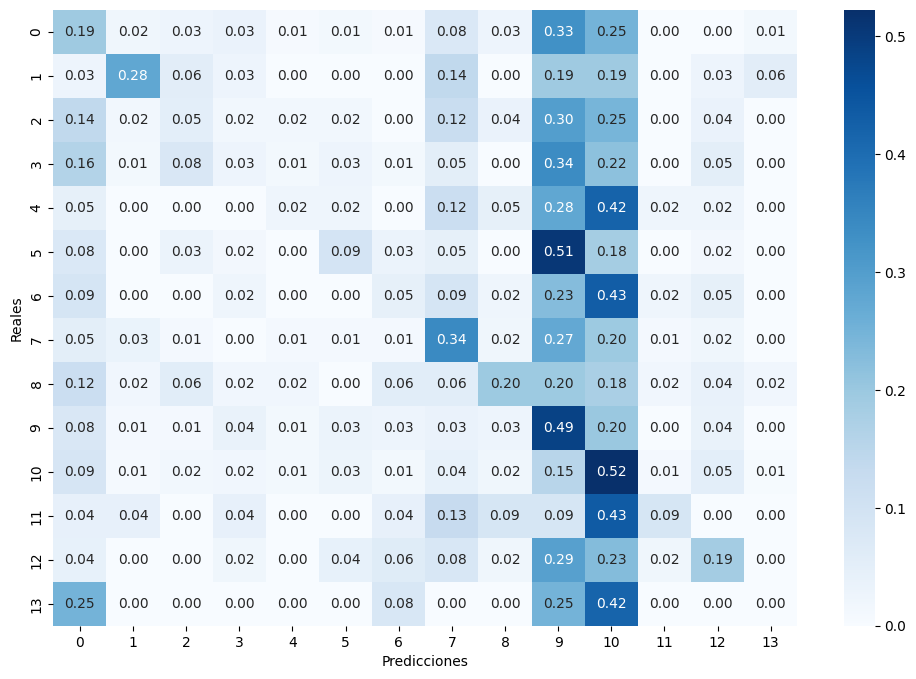

Matriz de Confusión Normalizada (por fila)
Modelo RandomForestClassifier (GRUPOREFERENCIA)


In [26]:
conf_matrix_normalized_sn(y_test, y_pred)
print("Matriz de Confusión Normalizada (por fila)\nModelo RandomForestClassifier (GRUPOREFERENCIA)")

## **12- Entrenamiento final con todos los datos X:**

1. Recálculo dinámico de parámetros:

- Calculamos safe_k_full basado en el mínimo de muestras de cualquier clase en el dataset completo (y_full).

- Ajustamos sampling_strategy para garantizar que cada clase tenga al menos safe_k_full + 1 muestras.

2. Actualización del modelo clonado:

- Usamos set_params() para modificar los parámetros de BorderlineSMOTE en el pipeline clonado.

- Esto evita intentar reducir muestras de clases que ya tienen más instancias que el objetivo original.

3. Entrenamiento sin estratificación:

- Al usar todos los datos, omitimos la validación cruzada en el ajuste final.

In [27]:
from sklearn.base import clone

best_model = search.best_estimator_

# Obtener los parámetros originales del SMOTE del mejor modelo
original_blsmote = best_model.named_steps['blsmote']

# Recalcular k_neighbors y sampling_strategy con TODOS los datos
X_full = pd.concat([X_train, X_test], axis=0)
y_full = pd.concat([y_train, y_test], axis=0)
y_full_counts = Counter(y_full["GRUPOREFERENCIA"].to_list())

# Ajustar parámetros de BorderlineSMOTE para el dataset completo
n_splits = cv.get_n_splits() if hasattr(cv, "n_splits") else 5  # Asumir 5 folds si no está disponible
adjusted_min_samples = max(1, int(min(y_full_counts.values()) * (n_splits - 1) // n_splits))
safe_k_full = max(1, adjusted_min_samples - 1)

# Clonar y actualizar el modelo con nuevos parámetros de SMOTE
final_model = clone(best_model)
final_model.named_steps['blsmote'].set_params(
    sampling_strategy={cls: max(count, safe_k_full + 1) for cls, count in y_full_counts.items()},
    k_neighbors=safe_k_full
)

BorderlineSMOTE(k_neighbors=45, random_state=7,
                sampling_strategy={0: 718, 1: 180, 2: 285, 3: 371, 4: 217,
                                   5: 323, 6: 222, 7: 458, 8: 256, 9: 1438,
                                   10: 1809, 11: 115, 12: 240, 13: 58})

In [28]:
# Entrenar con todos los datos (sin estratificación)
final_model.fit(X_full, y_full["GRUPOREFERENCIA"].values)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('nominal',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['FAMI_TIENECOMPUTADOR',
                                                   'ESTU_GENERO',
                                                   'FAMI_TIENESERVICIOTV',
                                                   'FAMI_TIENEINTERNET',
                                                   'FAMI_TIENEHORNOMICROOGAS',
                                                   'FAMI_TIENELAVADORA',
                                                   'FAMI_TIENEAUTOMOVIL',
                                                   'COLE_NATURALEZA',
                                                   'COLE_GENERO',
                                                   'COLE_CALENDARIO']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['FA...
                                                   'PUNT_C_NATURALES',
                                                   'PUNT_INGLES'])])),
                ('blsmote',
                 BorderlineSMOTE(k_neighbors=45, random_state=7,
                                 sampling_strategy={0: 718, 1: 180, 2: 285,
                                                    3: 371, 4: 217, 5: 323,
                                                    6: 222, 7: 458, 8: 256,
                                                    9: 1438, 10: 1809, 11: 115,
                                                    12: 240, 13: 58})),
                ('classifier',
                 RandomForestClassifier(bootstrap=False,
                                        class_weight='balanced_subsample',
                                        max_depth=20, min_samples_split=5,
                                        n_estimators=256, random_state=7))])

## **14- Guardar modelo final:**

In [29]:
joblib.dump(final_model, os.path.join(basedir, './models/best_model_RandomForestClassifier_final.pkl'))

['/home/jacques/Documentos/ml_study/FINALES/./models/best_model_RandomForestClassifier_final.pkl']

## **15- Predicción con el modelo final:**

In [30]:
X_test.iloc[7:8]

,FAMI_TIENECOMPUTADOR,ESTU_GENERO,FAMI_TIENESERVICIOTV,FAMI_TIENEINTERNET,FAMI_TIENEHORNOMICROOGAS,FAMI_TIENELAVADORA,FAMI_TIENEAUTOMOVIL,COLE_NATURALEZA,COLE_GENERO,COLE_CALENDARIO,...,FAMI_EDUCACIONMADRE,FAMI_PERSONASHOGAR,EDAD,LAT_COLE,LON_COLE,PUNT_LECTURA_CRITICA,PUNT_MATEMATICAS,PUNT_SOCIALES_CIUDADANAS,PUNT_C_NATURALES,PUNT_INGLES
579,NO,F,NO,NO,NO,NO,NO,OFICIAL,MIXTO,A,...,PRIMARIA INCOMPLETA,3 A 4,16.0,0.829022,-77.629513,55.0,67.0,64.0,63.0,49.0


In [31]:
model = joblib.load(os.path.join(basedir, './models/best_model_RandomForestClassifier_final.pkl'))
model.predict(X_test.iloc[7:8])

array([10])